# 266 Final project

## Intro

Short write up about our project and our goals



In [ ]:
## place to manually pip install failing libraries
!pip install Keras-Preprocessing
!pip install --user --upgrade tensorflow-model-optimization
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 675.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 2.1 MB/s eta 0:00:00


## Libraries

In [ ]:
import csv
import datetime
import io
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import string
import torch
import torch.nn as nn
import unicodedata

from google.colab import drive
from keras import preprocessing
from keras.callbacks import Callback
from keras.layers import Conv1D, Dense, Dropout, Embedding, Flatten, LSTM, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import AlbertTokenizerFast, AlbertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# TensorFlow Model Optimization (commented out, uncomment if needed)
# from tensorflow_model_optimization import sparsity

# Environment Variables
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Download NLTK Data
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dataset

### Load dataset

In [ ]:
# load dataset
# need to add tags from posts

def load_dataset(path):
    posts_df = pd.read_csv(path, names=["number", "comment", "label"], encoding="ISO-8859-1")
    print("\n\nFile '", path, "' loaded successfully")

    return posts_df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://www.kaggle.com/datasets/subhajeetdas/hate-comment

current_dir = '/content/drive/MyDrive/DataSci266Final/'
dataset = '/content/drive/MyDrive/DataSci266Final/hate.csv'
posts_df = load_dataset(dataset)

posts_df.head()



File ' /content/drive/MyDrive/DataSci266Final/hate.csv ' loaded successfully


,number,comment,label
0,NaN,comment,label
1,1.0,dalits are lowlives,N
2,2.0,gay people are a burden to our society,N
3,3.0,Arabs are not welcome,N
4,4.0,I'm not saying we should actually eliminate he...,N


In [ ]:
# Trim unnecessary column and headings
posts_df = posts_df.iloc[1:]
posts_df = posts_df.drop(columns=['number'])
posts_df.head()

,comment,label
1,dalits are lowlives,N
2,gay people are a burden to our society,N
3,Arabs are not welcome,N
4,I'm not saying we should actually eliminate he...,N
5,bananas are for black people,N


### Load pretrained vectors

In [ ]:
# Input: path to .vec file
# Output: Pandas DataFrame
# Uploads a pre-trained text model from file

def load_vectors(path):

    fin = io.open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}

    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=np.float32)

    print("\n\nPre-trained word vectors '", path,"' loaded successfully")

    return data

In [ ]:
# https://fasttext.cc/docs/en/english-vectors.html
# wiki-news-300d-1M.vec

pretrained_vector = '/content/drive/MyDrive/DataSci266Final/wiki-news-300d-1M.vec'
embeddings_index = load_vectors(pretrained_vector)



Pre-trained word vectors ' /content/drive/MyDrive/DataSci266Final/wiki-news-300d-1M.vec ' loaded successfully


### Data Preprocessing

In [ ]:
# Input: Pandas DataFrame
# Output: file name
# Performs data preprocessing returns name of file containing new dataset and
# file containing the most common words


def preprocessing(posts_df, current_dir):

    cur_part = 1

    posts_list = posts_df['comment'].tolist()

    # Constants
    # POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
    DI_POS_TYPES = {'NN': 'n', 'JJ': 'a', 'VB': 'v', 'RB': 'r'}
    POS_TYPES = list(DI_POS_TYPES.keys())

    # Constraints on tokens
    MIN_STR_LEN = 3
    RE_VALID = '[a-zA-Z]'

    # Get stopwords, stemmer and lemmatizer
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    # Remove all characters except for the 26x2 lowercase and uppercase English characters
    def remove_accents(data):
        return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters)

    # Process all posts
    li_tokens = []
    li_lem_strings = []

    print("post_list size:", len(posts_list))
    print("\n\nprocessing:")
    for i, text in enumerate(posts_list):
        if i % 1000 == 0:
            print(i, " out of 41144")

        # Tokenize by sentence, then by lowercase word
        tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

        # Process all tokens per post
        li_tokens_post = []
        li_tokens_post_lem = []
        for token in tokens:
            # Remove accents
            t = remove_accents(token)

            # Remove punctuation
            t = str(t).translate(string.punctuation)
            li_tokens_post.append(t)

            # Add token that represents "no lemmatization match"
            # li_tokens_post_lem.append("-") # this token will be removed if a lemmatization match is found below
            # Process each token
            if t not in stopwords:
                if re.search(RE_VALID, t):
                    if len(t) >= MIN_STR_LEN:
                        # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer
                        # (otherwise it assumes the word is a noun)
                        pos = nltk.pos_tag([t])[0][1][:2]
                        pos2 = 'n'  # set default to noun
                        if pos in DI_POS_TYPES:
                            pos2 = DI_POS_TYPES[pos]

                        stem = stemmer.stem(t)
                        lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                        if pos in POS_TYPES:
                            li_tokens.append((t, stem, lem, pos))

                            # Remove the "-" token and append the lemmatization match
                            li_tokens_post_lem.append(lem)

        # Build list of strings from lemmatized tokens
        str_li_tokens_post_lem = ' '.join(li_tokens_post_lem)
        li_lem_strings.append(str_li_tokens_post_lem)

    df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem post'])

    print("\n\ndf_lem_strings.head():", df_lem_strings.head().to_string())

    # Add counts
    print("\n\nGroup by lemmatized words, add count and sort")
    df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
    df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
    df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

    print("\n\nGet just the first row in each lemmatized group")
    df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
    print("\n\ndf_words.head(10):", df_words.head(10))

    li_token_flat = [y for x in li_tokens for y in x]  # flatten the list of token lists to a single list
    print("\n\nli_token_lists_flat[:10]:", li_token_flat[:10])

    di_freq = nltk.FreqDist(li_token_flat)
    del di_freq['']
    li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
    print(li_freq_sorted)

    di_freq.plot(30, cumulative=False)

    li_lem_words = df_all_words['lem'].tolist()
    di_freq2 = nltk.FreqDist(li_lem_words)
    li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
    print(li_freq_sorted2)

    di_freq2.plot(30, cumulative=False)
    mcw_file_name = "most_common_words.csv"
    mcw_file_path = os.path.join(current_dir, mcw_file_name)
    dls_file_name = "df_lem_strings.csv"
    dls_file_path = os.path.join(current_dir, dls_file_name)

    if cur_part == 1:
        most_common_words = [word for word, count in di_freq2.most_common(1000)]
        most_common_words = pd.DataFrame(most_common_words, columns=["word"])
        most_common_words.to_csv(mcw_file_path, index=False)
        df_lem_strings.to_csv(dls_file_path, index=False)
    else:
        most_common_words = load_csv(mcw_file_name)

    df_lem_strings['top lem post'] = df_lem_strings['lem post']\
        .apply(lambda x: [word for word in x.split(' ') if word in most_common_words['word'].to_list()]).str.join(' ')

    df_lem_strings.to_csv(dls_file_path, index=False)

    print("\n\nThe following files were created: ")
    print(mcw_file_name)
    print(dls_file_name)

post_list size: 41144


processing:
0  out of 41144
1000  out of 41144
2000  out of 41144
3000  out of 41144
4000  out of 41144
5000  out of 41144
6000  out of 41144
7000  out of 41144
8000  out of 41144
9000  out of 41144
10000  out of 41144
11000  out of 41144
12000  out of 41144
13000  out of 41144
14000  out of 41144
15000  out of 41144
16000  out of 41144
17000  out of 41144
18000  out of 41144
19000  out of 41144
20000  out of 41144
21000  out of 41144
22000  out of 41144
23000  out of 41144
24000  out of 41144
25000  out of 41144
26000  out of 41144
27000  out of 41144
28000  out of 41144
29000  out of 41144
30000  out of 41144
31000  out of 41144
32000  out of 41144
33000  out of 41144
34000  out of 41144
35000  out of 41144
36000  out of 41144
37000  out of 41144
38000  out of 41144
39000  out of 41144
40000  out of 41144
41000  out of 41144


df_lem_strings.head():                                                      lem post
0                                             dali

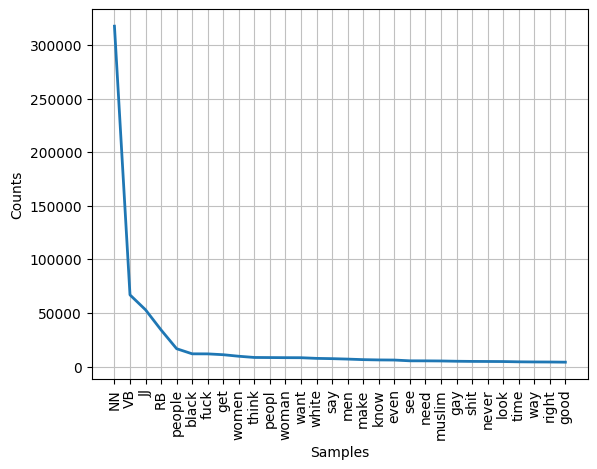

[('people', 8339), ('woman', 5950), ('fuck', 5037), ('get', 4472), ('black', 4222), ('say', 3256), ('think', 2927), ('want', 2900), ('make', 2818), ('white', 2671), ('men', 2307), ('country', 2218), ('muslim', 2202), ('know', 2199), ('see', 2127), ('even', 2017), ('need', 1907), ('gay', 1781), ('look', 1780), ('go', 1709), ('well', 1691), ('shit', 1604), ('really', 1602), ('jew', 1585), ('come', 1567), ('never', 1564), ('time', 1553), ('right', 1535), ('many', 1507), ('thing', 1507), ('take', 1496), ('way', 1452), ('life', 1379), ('call', 1372), ('use', 1366), ('good', 1347), ('work', 1347), ('man', 1304), ('bad', 1303), ('world', 1295), ('much', 1276), ('love', 1272), ('refugee', 1174), ('try', 1125), ('always', 1107), ('let', 1102), ('give', 1099), ('year', 1051), ('immigrant', 1044), ('actually', 1028), ('asian', 1018), ('back', 1006), ('kid', 999), ('lot', 988), ('believe', 982), ('child', 982), ('trans', 981), ('feel', 961), ('race', 957), ('stop', 918), ('also', 915), ('live', 91

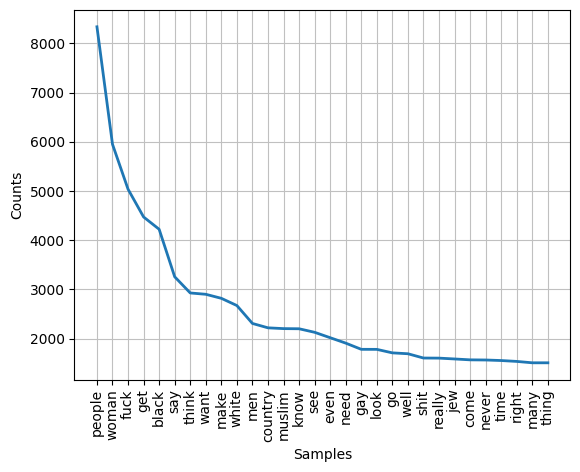



The following files were created: 
most_common_words.csv
df_lem_strings.csv


In [ ]:
preprocessing(posts_df, current_dir)

### Split data for training

In [ ]:
# Input: Pandas DataFrame, Pandas DataFrame, Dictionary
# Output: X_train, X_test, y_train, y_test, int, int, int
# Splits the dataset into training and testing set. It also returns number of
# words, max length of a tweet, and the embedding dimension

def data_split(data, dls, word_vectors):

    embeddings_index = word_vectors

    # Load your data and remove rows with NaN values
    posts_df = data
    df_lem_strings = dls
    df_lem_strings = df_lem_strings.dropna()


    # Convert the labels to the required format
    labels = posts_df["label"].tolist()
    labels = np.array([label.upper() for label in labels])
    labels = labels[df_lem_strings.index]
    labels = np.array([0 if label == "N" else (1 if label == "P" else '') for label in labels])


    # Only keep items for remaining rows
    valid_indices = labels != ''
    labels = labels[valid_indices]
    text = df_lem_strings["top lem post"].tolist()
    filtered_text = [item for item, keep in zip(text, valid_indices) if keep]
    text = filtered_text

    # Tokenize the text data
    max_words = 5000
    tokenizer = Tokenizer(num_words=max_words, split=' ')
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)

    # Truncate or pad sequences to max_len
    max_len = 150
    word_index = tokenizer.word_index
    num_words = min(max_words, len(word_index) + 1)
    embedding_dim = 300
    embedding_matrix = np.zeros((num_words, embedding_dim))

    print("word index size:", len(word_index))

    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i, :embedding_dim] = embedding_vector[:embedding_dim]

    print("sequences size: ", len(sequences))

    data = pad_sequences(sequences, maxlen=max_len)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Print a message indicating that the data has been split successfully
    print("\n\nData Successfully split for training")

    # Return the training and testing sets, along with other relevant data
    return X_train, X_test, y_train, y_test, num_words, max_len, embedding_dim, embedding_matrix


In [ ]:
from pandas import read_csv

dls_name = "/content/drive/MyDrive/DataSci266Final/df_lem_strings.csv"
dls = read_csv(dls_name)
X_train, X_test, y_train, y_test, num_words, max_len, embedding_dim, embedding_matrix = data_split(posts_df, dls, embeddings_index)

word index size: 1000
sequences size:  40376


Data Successfully split for training


In [ ]:
y_test = y_test.astype(int)
y_train = y_train.astype(int)

## Models

### Random Forest

In [ ]:
# Input: X_train, X_test, y_train, y_test
# Output: Confusion matrix
# Defines and trains a Random Forest Model

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, auc)

def random_forest_model(x_train, x_test, y_train, y_test):

    start_time = datetime.datetime.now()
    print("\n\nRandom Forest Model training ... ")

    # creating RF classifier with oob_score=True
    rfc = RandomForestClassifier(n_estimators=100, oob_score=True)

    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    rfc.fit(x_train, y_train)

    # performing predictions on the test dataset
    y_pred = rfc.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time

    print("Model Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("Elapsed time: ", elapsed_time)
    print("\n\n")

    # Plot the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Random Forest)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\n\n")


    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, rfc.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
    plt.legend(loc='lower right')
    plt.show()




Random Forest Model training ... 
Model Accuracy:  0.5310797424467558
Precision:  0.4846724749919329
Recall:  0.4068255687973998
F1 Score:  0.44235016934177585
Elapsed time:  0:00:10.219921





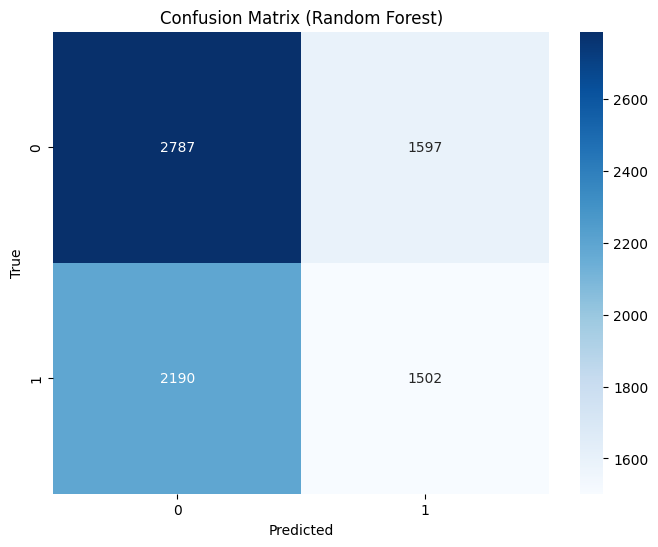

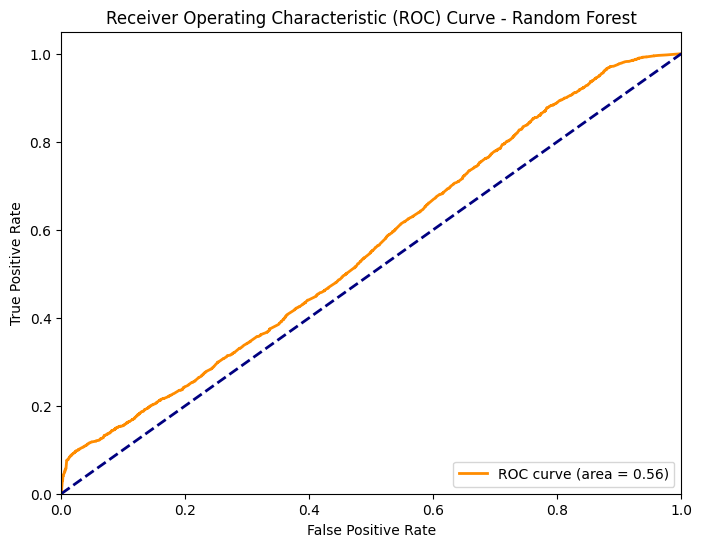

In [ ]:
random_forest_model(X_train, X_test, y_train, y_test)

### Linear Regression



In [ ]:
# Input: X_train, X_test, y_train, y_test
# Output: Density plot and scatter plot
# Defines and trains a Linear Regression Model

def linear_regression_model(x_train, x_test, y_train, y_test):

    start_time = datetime.datetime.now()
    print("\n\nLinear Regression Model training ... ")

    # Scale the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Creating a logistic regression classifier
    clf = LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=5000)

    # Training the model on the training dataset
    clf.fit(x_train, y_train)

    # Performing predictions on the test dataset
    y_pred = clf.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of the Model: ", accuracy)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time
    print("Elapsed time: ", elapsed_time)
    print("\n\n")

    # Plot a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Linear Regression)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\n\n")

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Linear Regression')
    plt.legend(loc='lower right')
    plt.show()




Linear Regression Model training ... 
Accuracy of the Model:  0.5404903417533432
Precision:  0.4875491480996068
Recall:  0.10075839653304441
F1 Score:  0.167003367003367
Elapsed time:  0:04:59.515432





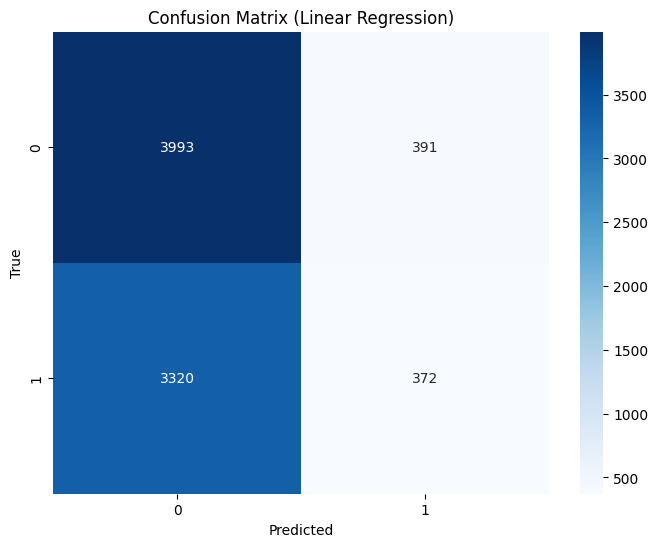

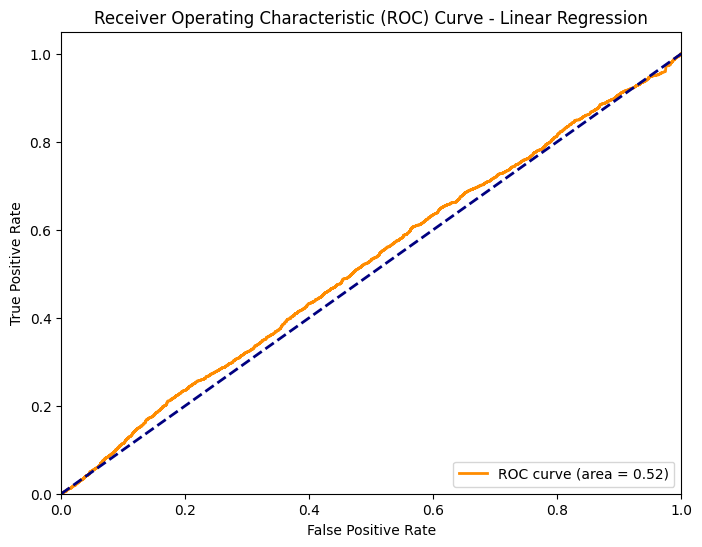

In [ ]:
linear_regression_model(X_train, X_test, y_train, y_test)

### CNN-LSTM

In [ ]:
# Input: X_train, X_test, y_train, y_test, int, int, in
# Output: NULL
# Build and Train CNN-LSTM

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, auc)

def cnn_lstm(x_train, x_test, y_train, y_test, num_words, max_len, embedding_dim, embedding_matrix):

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)


    # create the model
    start_time = datetime.datetime.now()

    model = Sequential([
        Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len,
              trainable=False),
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("\n\nConvolutional Neural Network Summary: ")
    model.summary()

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

    # print training duration
    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time
    print("Elapsed time: ", elapsed_time)

    # Evaluate the model
    print("\n\nDense Neural Network Evaluation:")
    score = model.evaluate(x_test, y_test)
    print('Test accuracy:', score[1])

    # Make predictions on the test set
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    print("Model Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time

    print("Elapsed time: ", elapsed_time)
    print("\n\n")

    # Build the confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix (CNN-LSTM)')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    print("\n\n")

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - CNN-LSTM')
    plt.legend(loc='lower right')
    plt.show()




Convolutional Neural Network Summary: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          300300    
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 32)           28832     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 75, 32)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 382433 (1.46 MB)
Trainable params: 82133 (320.83 KB)
Non-trainabl

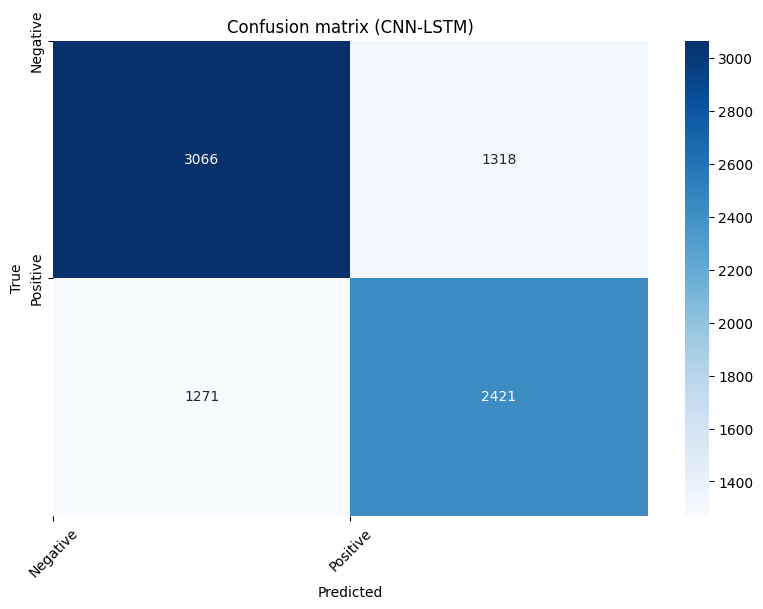

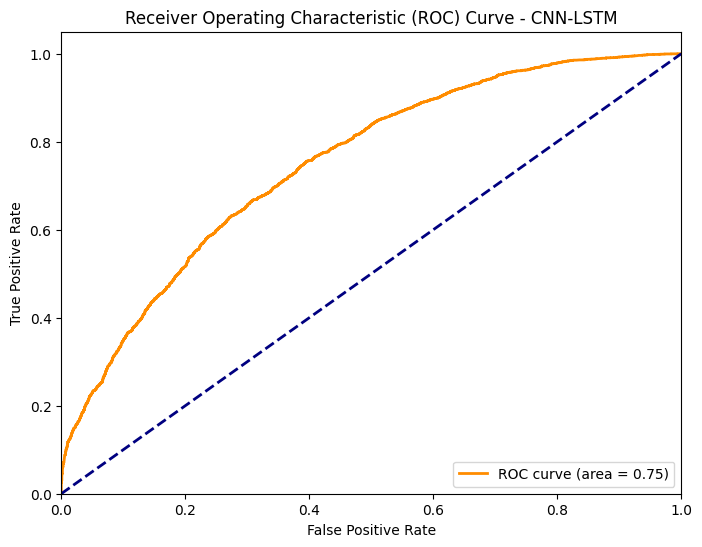

In [ ]:
cnn_lstm(X_train, X_test, y_train, y_test, num_words, max_len, embedding_dim, embedding_matrix)


### ALBERT 01 - Data Preprocessing and Prep


In [ ]:
# Initialize the tokenizer (update this according to your model)
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

# Function to load dataset
def load_dataset(path):
    posts_df = pd.read_csv(path, names=["number", "comment", "label"], encoding="ISO-8859-1", header=None, skiprows=1)
    print("\n\nFile '", path, "' loaded successfully")
    return posts_df

# Function for basic text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove all non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

# Function to prepare data
def prepare_data(df):
    df = df.copy()
    # Map 'N' to 0 and 'P' to 1
    label_mapping = {'N': 0, 'P': 1}
    df['label'] = df['label'].map(label_mapping)
    # Clean the comments
    df['comment'] = df['comment'].apply(clean_text)
    # Handle or remove invalid labels
    df = df[df['label'].isin([0, 1])]  # Keep only rows with valid labels
    sentences = df['comment'].astype(str).tolist()  # Convert to list of strings
    labels = df['label'].values
    # Convert labels to a PyTorch tensor
    labels = torch.tensor(labels, dtype=torch.long)
    return sentences, labels

# Load dataset
drive.mount('/content/drive')
current_dir = '/content/drive/MyDrive/DataSci266Final/'
dataset = '/content/drive/MyDrive/DataSci266Final/hate.csv'
posts_df = load_dataset(dataset)

# Drop unnecessary column
posts_df = posts_df.drop(columns=['number'])

# Split the data into training and testing dataframes
train_df = posts_df.sample(frac=0.8, random_state=42)
test_df = posts_df.drop(train_df.index)

# Prepare the training and testing data
train_sentences, train_labels = prepare_data(train_df)
test_sentences, test_labels = prepare_data(test_df)

# Encode sequences for the training and testing sets
# Updated Function to Encode Sequences
def encode_sequences(sentences):
    # Ensure that sentences is a list of strings
    if isinstance(sentences, list) and all(isinstance(s, str) for s in sentences):
        encoded_batch = tokenizer(sentences,
                                  add_special_tokens=True,
                                  max_length=512,
                                  padding='max_length',
                                  truncation=True,
                                  return_attention_mask=True,
                                  return_tensors='pt')
    else:
        raise ValueError("Sentences should be a list of strings.")

    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']
    return input_ids, attention_masks

train_input_ids, train_attention_masks = encode_sequences(train_sentences)
test_input_ids, test_attention_masks = encode_sequences(test_sentences)

# Define a batch size
batch_size = 6


# Function to create a DataLoader
def create_dataloader(input_ids, attention_masks, labels, batch_size):
    # Create a TensorDataset from the input IDs, attention masks, and labels
    data = TensorDataset(input_ids, attention_masks, labels)

    # Use RandomSampler for randomizing the data during training
    sampler = RandomSampler(data)

    # Create the DataLoader
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return dataloader

# Create DataLoaders for training and testing sets
train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_labels, batch_size)
test_dataloader = create_dataloader(test_input_ids, test_attention_masks, test_labels, batch_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


File ' /content/drive/MyDrive/DataSci266Final/hate.csv ' loaded successfully


In [ ]:
# Load AlbertForSequenceClassification
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Set optimizer, epochs, steps
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define metric placeholders
train_loss_values = []
train_acc_values = []
train_precision_values = []
train_recall_values = []
train_f1_values = []

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Define the number of steps for gradient accumulation
accumulation_steps = 4

# Training loop
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    total_train_acc = 0
    predictions, true_labels = [], []

    model.train()
    optimizer.zero_grad()  # Reset gradients at the start of each epoch

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss / accumulation_steps  # Scale down the loss
        loss.backward()

        if (step + 1) % accumulation_steps == 0:  # Perform optimization step
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()  # Clear gradients

        total_train_loss += loss.item() * accumulation_steps  # Scale up the loss to its actual value

        preds = torch.argmax(outputs.logits, dim=1).flatten()
        acc = (preds == b_labels).cpu().numpy().mean() * 100
        total_train_acc += acc

        predictions.append(preds.detach().cpu().numpy())
        true_labels.append(b_labels.detach().cpu().numpy())

        torch.cuda.empty_cache()  # Free up unutilized memory

    # Metrics calculation
    if predictions and true_labels:
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        avg_train_precision = precision_score(true_labels, predictions)
        avg_train_recall = recall_score(true_labels, predictions)
        avg_train_f1 = f1_score(true_labels, predictions)
    else:
        print("Warning: Predictions or True Labels list is empty. Metrics calculation skipped.")
        avg_train_precision = avg_train_recall = avg_train_f1 = 0

    # Calculate and store metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_acc = total_train_acc / len(train_dataloader)
    train_loss_values.append(avg_train_loss)
    train_acc_values.append(avg_train_acc)
    train_precision_values.append(avg_train_precision)
    train_recall_values.append(avg_train_recall)
    train_f1_values.append(avg_train_f1)

    # Print training epoch metrics
    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Average training accuracy: {avg_train_acc:.2f}")
    print(f"Average training precision: {avg_train_precision:.2f}")
    print(f"Average training recall: {avg_train_recall:.2f}")
    print(f"Average training F1 score: {avg_train_f1:.2f}")

    # Validation
    print("\nRunning Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss.item()
            total_eval_loss += loss
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        torch.cuda.empty_cache()  # Free up unutilized memory

    # Calculate and print validation metrics
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

======== Epoch 1 / 2 ========
  Batch    40  of  5,482.
  Batch    80  of  5,482.
  Batch   120  of  5,482.
  Batch   160  of  5,482.
  Batch   200  of  5,482.
  Batch   240  of  5,482.
  Batch   280  of  5,482.
  Batch   320  of  5,482.
  Batch   360  of  5,482.
  Batch   400  of  5,482.
  Batch   440  of  5,482.
  Batch   480  of  5,482.
  Batch   520  of  5,482.
  Batch   560  of  5,482.
  Batch   600  of  5,482.
  Batch   640  of  5,482.
  Batch   680  of  5,482.
  Batch   720  of  5,482.
  Batch   760  of  5,482.
  Batch   800  of  5,482.
  Batch   840  of  5,482.
  Batch   880  of  5,482.
  Batch   920  of  5,482.
  Batch   960  of  5,482.
  Batch 1,000  of  5,482.
  Batch 1,040  of  5,482.
  Batch 1,080  of  5,482.
  Batch 1,120  of  5,482.
  Batch 1,160  of  5,482.
  Batch 1,200  of  5,482.
  Batch 1,240  of  5,482.
  Batch 1,280  of  5,482.
  Batch 1,320  of  5,482.
  Batch 1,360  of  5,482.
  Batch 1,400  of  5,482.
  Batch 1,440  of  5,482.
  Batch 1,480  of  5,482.
  Batch 

In [ ]:
# Testing loop
print('======== Testing ========')

# Define lists to store per-batch metrics
batch_losses = []
batch_accuracies = []
batch_precisions = []
batch_recalls = []
batch_f1s = []

# Reset the values of predictions and true_labels
predictions, true_labels = [], []

loss_fn = nn.CrossEntropyLoss()

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate loss
    loss = loss_fn(outputs.logits, b_labels)
    batch_losses.append(loss.item())

    # Use argmax to get the predicted labels
    preds = np.argmax(logits, axis=1).flatten()

    # Compute metrics
    batch_accuracy = accuracy_score(label_ids, preds)
    batch_precision = precision_score(label_ids, preds, zero_division=1)
    batch_recall = recall_score(label_ids, preds, zero_division=1)
    batch_f1 = f1_score(label_ids, preds, zero_division=1)

    # Store metrics
    batch_accuracies.append(batch_accuracy)
    batch_precisions.append(batch_precision)
    batch_recalls.append(batch_recall)
    batch_f1s.append(batch_f1)

    # Store predictions and true labels for later evaluation
    predictions.extend(preds)
    true_labels.extend(label_ids)

# Recalculate the metrics for the test set
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions)
test_recall = recall_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions)

# Update the test_summary_data with the recalculated metrics
test_summary_data = {
    'Average Loss': [np.mean(batch_losses)],
    'Accuracy': [test_accuracy],
    'Precision': [test_precision],
    'Recall': [test_recall],
    'F1-Score': [test_f1],
}

# Recreate the DataFrame
test_summary_df = pd.DataFrame(test_summary_data)

print("\nTesting Summary:")
display(test_summary_df)

======== Testing ========

Testing Summary:


,Average Loss,Accuracy,Precision,Recall,F1-Score
0,0.449014,0.787956,0.726719,0.872746,0.793067


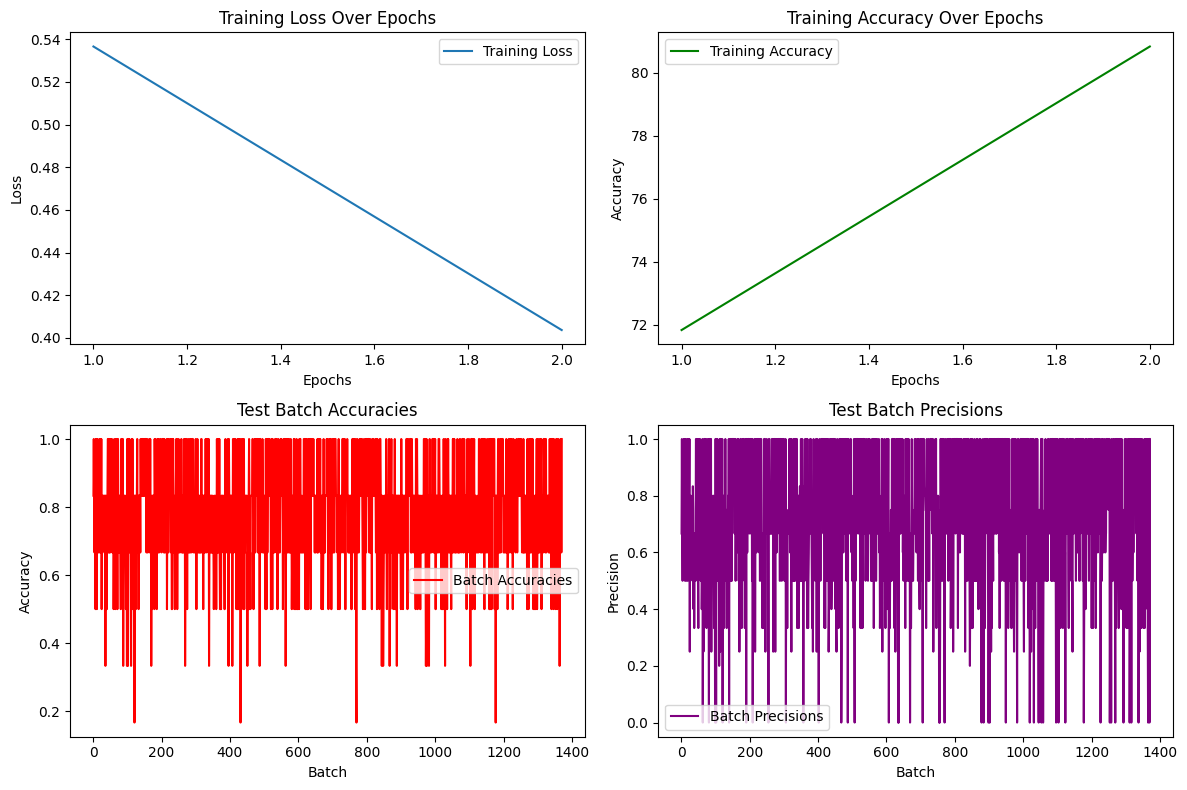

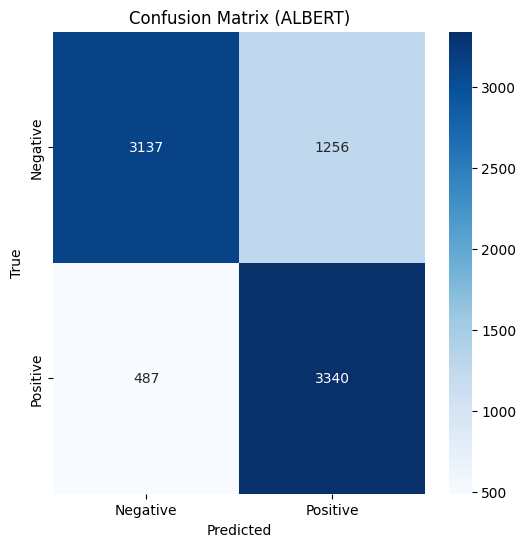

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Training Metrics Visualization
epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_values, label='Training Accuracy', color='g')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing Batch Metrics Visualization
batches = range(1, len(batch_accuracies) + 1)

plt.subplot(2, 2, 3)
plt.plot(batches, batch_accuracies, label='Batch Accuracies', color='r')
plt.title('Test Batch Accuracies')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(batches, batch_precisions, label='Batch Precisions', color='purple')
plt.title('Test Batch Precisions')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix for the Test Data
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ALBERT)')
plt.show()


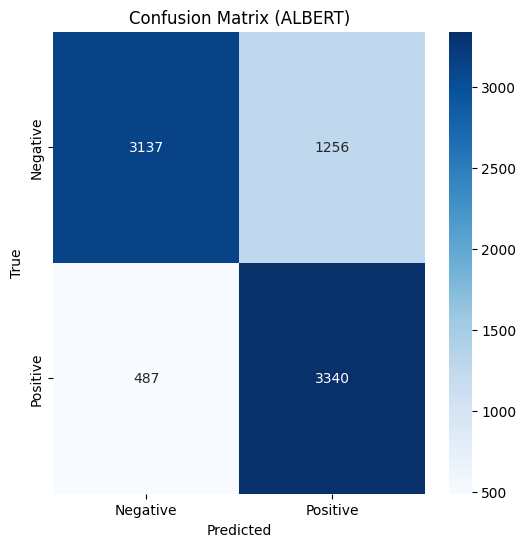

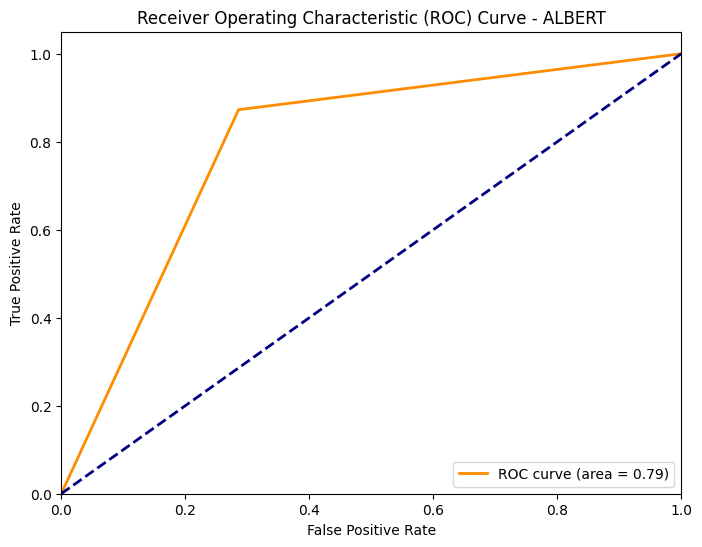

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Assuming you have true_labels and predictions for your test data
# And true positive rates (tpr), false positive rates (fpr), and roc_auc available from your model's output

# Confusion Matrix for the Test Data
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ALBERT)')
plt.show()

# ROC Curve Visualization
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ALBERT')
plt.legend(loc='lower right')
plt.show()


### Notes